In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# read in data, taking 10% sample
p = .8
required_cols = ['JobID','Partition', 'Account', 'Group', 'GID',
       'User', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed',
       'ExitCode', 'State', 'NNodes', 'NCPUS', 'ReqCPUS', 'ReqMem', 'ReqGRES',
       'ReqTRES', 'Timelimit', 'NodeList', 'JobName']
accre = pd.read_csv('data/accre_data.txt', header=0, sep='|', usecols=required_cols, skiprows=lambda i: i>0 and random.random() > p)

## DISCOVERY

In [2]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248960 entries, 0 to 1248959
Data columns (total 22 columns):
JobID        1248960 non-null object
Partition    1238004 non-null object
Account      1248960 non-null object
Group        1248960 non-null object
GID          1248960 non-null int64
User         1248960 non-null object
Submit       1248960 non-null object
Eligible     1248960 non-null object
Start        1248960 non-null object
End          1248960 non-null object
Elapsed      1248960 non-null object
ExitCode     1248960 non-null object
State        1248960 non-null object
NNodes       1248960 non-null int64
NCPUS        1248960 non-null int64
ReqCPUS      1248960 non-null int64
ReqMem       1248960 non-null object
ReqGRES      8385 non-null object
ReqTRES      1238004 non-null object
Timelimit    1238004 non-null object
NodeList     1248960 non-null object
JobName      1248958 non-null object
dtypes: int64(4), object(18)
memory usage: 209.6+ MB


In [3]:
# look at the shape of the dataset
accre.shape

(1248960, 22)

## CLEANUP

In [4]:
# convert partition & account to category
accre.Partition = accre.Partition.astype('category')
accre.Account = accre.Account.astype('category')
accre.dtypes

JobID          object
Partition    category
Account      category
Group          object
GID             int64
User           object
Submit         object
Eligible       object
Start          object
End            object
Elapsed        object
ExitCode       object
State          object
NNodes          int64
NCPUS           int64
ReqCPUS         int64
ReqMem         object
ReqGRES        object
ReqTRES        object
Timelimit      object
NodeList       object
JobName        object
dtype: object

In [5]:
# convert Submit and Start to datetime
accre['Submit'] = pd.to_datetime(accre['Submit'], format='%Y/%m/%d')
accre['Start'] = pd.to_datetime(accre['Start'], format='%Y/%m/%d')

In [6]:
# create Queue_Time column = Start - Submit
accre['Queue_Time'] = accre['Start'] - accre['Submit']
accre.Queue_Time.head()

0   03:01:45
1   03:41:41
2   07:47:14
3   00:00:06
4   00:00:06
Name: Queue_Time, dtype: timedelta64[ns]

In [7]:
# check data types
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248960 entries, 0 to 1248959
Data columns (total 23 columns):
JobID         1248960 non-null object
Partition     1238004 non-null category
Account       1248960 non-null category
Group         1248960 non-null object
GID           1248960 non-null int64
User          1248960 non-null object
Submit        1248960 non-null datetime64[ns]
Eligible      1248960 non-null object
Start         1248960 non-null datetime64[ns]
End           1248960 non-null object
Elapsed       1248960 non-null object
ExitCode      1248960 non-null object
State         1248960 non-null object
NNodes        1248960 non-null int64
NCPUS         1248960 non-null int64
ReqCPUS       1248960 non-null int64
ReqMem        1248960 non-null object
ReqGRES       8385 non-null object
ReqTRES       1238004 non-null object
Timelimit     1238004 non-null object
NodeList      1248960 non-null object
JobName       1248958 non-null object
Queue_Time    1248960 non-null timedel

In [8]:
# head data exploration for each column
for column in list(accre.columns):
    print(accre[column].value_counts(normalize=False,ascending=False).head(10))
    print('')
    print('')
    

26828657_80     2
26828657_3      2
26827147_95     2
26828657_93     2
26763523_10     2
26763523_2      2
19224420_119    2
26764369_18     2
26748983_46     2
26378429_175    1
Name: JobID, dtype: int64


production    1229009
pascal           5749
maxwell          3156
debug              46
bigbox             25
mic                17
fermi               2
Name: Partition, dtype: int64


cms                  353796
beam_lab             143984
cms_lowprio           92658
p_csb_meiler          76352
cms_stage2            66411
mip_eecs              57559
h_biostat_student     44862
lola                  44288
p_meiler              42654
math                  36906
Name: Account, dtype: int64


cms                  506391
beam_lab             149051
p_csb_meiler          73856
mip_eecs              57726
cms_stage1            45588
p_meiler              45479
lola                  45021
h_biostat_student     44831
math                  36906
rokaslab              30323
Name: Group, dty

## BEGIN WORK ON QUESTION

In [9]:
#get count of status
state_messages = accre.State.value_counts().to_frame().reset_index()
state_messages.columns = ["status","count"]
state_messages.head(20)

import re
condition = re.compile("CANCELLED by\s\d*")
state_messages['status'] = state_messages.status.replace(to_replace=condition,value="CANCELLED")
state_messages.groupby("status")["count"].sum().to_frame().reset_index()


,status,count
0,CANCELLED,426561
1,COMPLETED,714375
2,FAILED,90648
3,NODE_FAIL,236
4,PREEMPTED,1363
5,TIMEOUT,15777


In [10]:
# get jobs run per node (count of JobID grouped by NodeList)
jobs_per_node = accre.JobID.groupby(accre['NodeList']).agg('count')
jobs_per_node = jobs_per_node.to_frame()
jobs_per_node = jobs_per_node.iloc[1:,:]
jobs_per_node = jobs_per_node.sort_values(by="JobID",ascending=False)
jobs_per_node.head()

,JobID
NodeList,
vmp1409,9456
vmp1242,7906
vmp1257,7522
vmp1001,6644
vmp1298,4620


In [11]:
#jobs failed per node (count of JobID grouped by NodeList from )
state_failed = ['NODE_FAIL']
state_bad = accre.loc[accre['State'].isin(state_failed)]
fails_per_node = state_bad.JobID.groupby(state_bad['NodeList']).agg('count')
fails_per_node = fails_per_node.to_frame()
fails_per_node = fails_per_node.sort_values(by="JobID",ascending=False)
fails_per_node.head()

,JobID
NodeList,
vmp1223,4
vmp1055,4
vmp1349,4
vmp1374,3
vmp1350,3


In [12]:
#merge jobs run and jobs failed
node_fails_table = pd.merge(jobs_per_node,fails_per_node,on='NodeList',how='left')
node_fails_table = node_fails_table.rename({'JobID_x':'JobRuns','JobID_y':'JobFails'},axis=1)
node_fails_table.head()

,JobRuns,JobFails
NodeList,,
vmp1409,9456,NaN
vmp1242,7906,NaN
vmp1257,7522,NaN
vmp1001,6644,NaN
vmp1298,4620,NaN


In [13]:
#drop rows missing data
##should first check how many rows that will be
node_fails_table = node_fails_table.dropna()

#create Fail% column & sort
node_fails_table['Fail%'] = node_fails_table.JobFails/node_fails_table.JobRuns
node_fails_table.sort_values(by='JobRuns', ascending=False)

,JobRuns,JobFails,Fail%
NodeList,,,
vmp1003,3877,1.0,0.000258
vmp1370,3057,1.0,0.000327
vmp1066,2996,1.0,0.000334
vmp1027,2883,1.0,0.000347
vmp1063,2762,1.0,0.000362
vmp1029,2637,2.0,0.000758
vmp1065,2603,1.0,0.000384
vmp1078,2581,1.0,0.000387
vmp1385,2577,1.0,0.000388


In [14]:
#drop rows with no jobs failed or <100 jobs run
condition1 = node_fails_table.JobFails != 0
condition2 = node_fails_table.JobRuns > 100

node_fails_table = node_fails_table[condition1&condition2]

In [18]:
#show sorted table
node_fails_table = node_fails_table.sort_values(by='Fail%',ascending=False)
node_fails_table

,JobRuns,JobFails,Fail%
NodeList,,,
vmp692,118,3.0,0.025424
gpu0010,101,1.0,0.009901
vmp697,108,1.0,0.009259
vmp592,115,1.0,0.008696
vmp1223,669,4.0,0.005979
vmp690,523,2.0,0.003824
vmp323,840,3.0,0.003571
vmp500,944,3.0,0.003178
gpu0015,330,1.0,0.003030


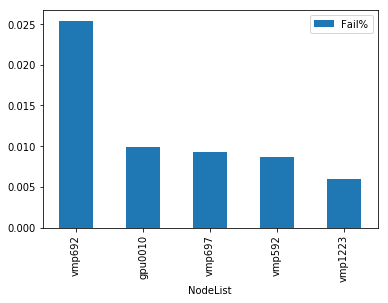

In [41]:
#barplot of top 5 
node_fails_table[["Fail%"]].iloc[0:5,:].plot(kind="bar")